In [1]:
# Set the first GPU as visible
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
import cv2
import sys
import torch
import numpy as np

sys.path.append('/home/sebastian.cavada/scsv/thesis/mast3r_mine')
import mast3r.utils.path_to_dust3r  # noqa

from dust3r.inference import inference
from dust3r.model import AsymmetricCroCo3DStereo
from dust3r.utils.image import load_images
from dust3r.image_pairs import make_pairs
from dust3r.cloud_opt import global_aligner, GlobalAlignerMode

from mast3r.model import AsymmetricMASt3R

import matplotlib.pyplot as plt
import imageio.v2 as imageio

import torch
import torch.nn.functional as F

import os
import json

import numpy as np
from pathlib import Path

import sys
import imageio.v2 as imageio
import matplotlib.pyplot as plt

from typing import Set
sys.path.append('/home/sebastian.cavada/scsv/thesis/mast3r_mine/dust3r')

from dust3r.utils.geometry import depthmap_to_pts3d, depthmap_to_camera_coordinates, depthmap_to_absolute_camera_coordinates # nofq
import dust3r.datasets.utils.cropping as cropping

# Specify the folder containing JSON files
folder_path = './arkitscenes_pairs/Training'

file_name = folder_path + "/scene_list.json"
print(file_name)

with open(file_name, 'r') as file:
    scene_list = json.load(file)

    # print(scene_list)

gt_path = Path('/data3/sebastian.cavada/datasets/arkitscenes_test/Training')

./arkitscenes_pairs/Training/scene_list.json


/home/sebastian.cavada/scsv/thesis/mast3r_mine/dust3r/dust3r/cloud_opt/base_opt.py:275: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


/home/sebastian.cavada/micromamba/envs/mast3r/lib/python3.11/site-packages/imageio/plugins/pillow.py:320: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


[[-0.00447814 -0.53430494  0.84527994  0.25813778]
 [-0.99502903 -0.08171314 -0.0569227   0.09428441]
 [ 0.09948456 -0.84133298 -0.53128301 -0.1407484 ]
 [ 0.          0.          0.          1.        ]]
/data3/sebastian.cavada/datasets/arkitscenes_test/Training/47334185/vga_wide/47334185_354503.582.jpg /data3/sebastian.cavada/datasets/arkitscenes_test/Training/47334185/vga_wide/47334185_354510.479.jpg
[[423.89800212   0.         256.366     ]
 [  0.         423.89800212 192.3666    ]
 [  0.           0.           1.        ]]
<PIL.Image.Image image mode=RGB size=512x384 at 0x7035E7F31010> <PIL.Image.Image image mode=RGB size=512x384 at 0x7035E43395D0>


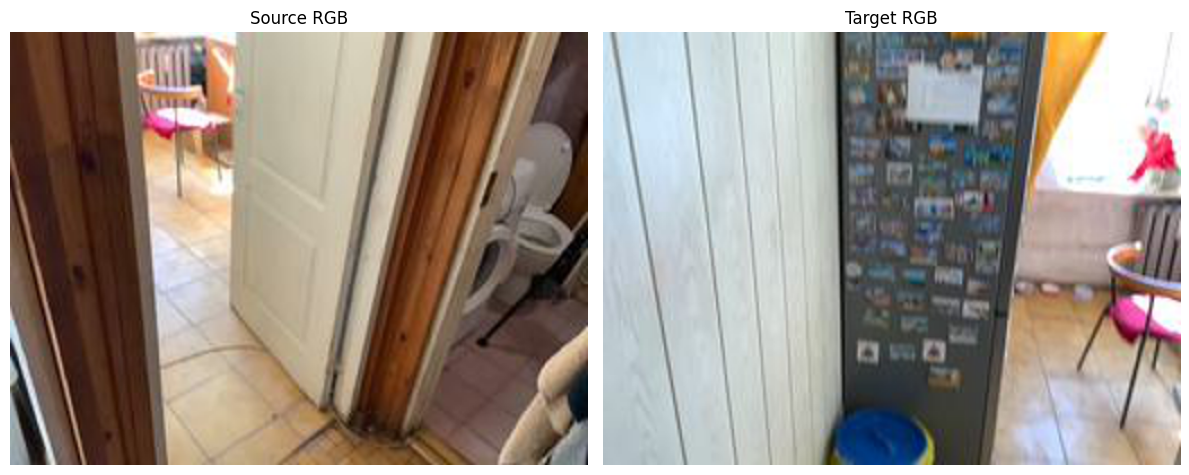

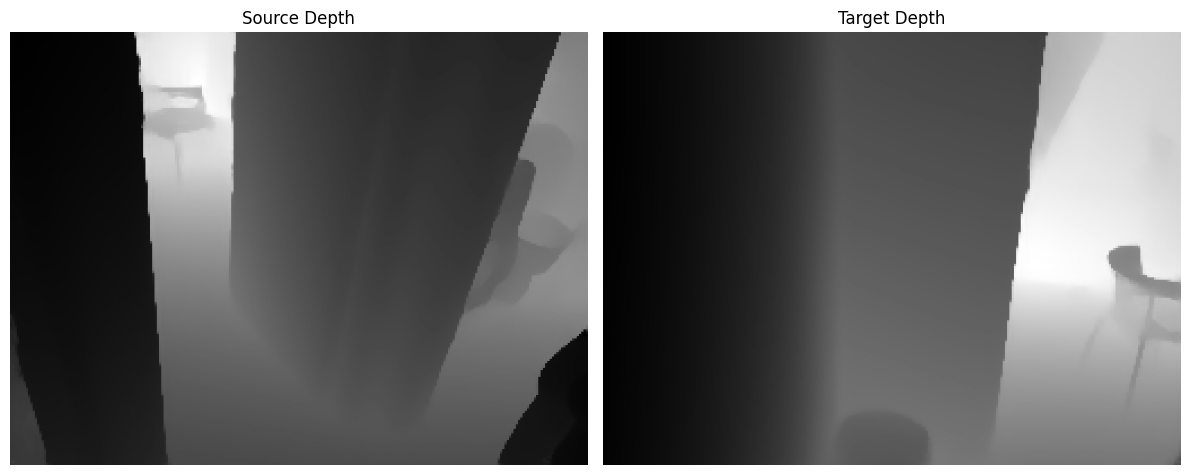

(384, 512, 3)
(384, 512, 3)


In [3]:
np.random.seed(42)

for scene in scene_list[69:70]:    
    scene_path = Path(folder_path) / scene / "selected_pairs.npz"
    # print(scene_path)
    data = np.load(scene_path, allow_pickle=True)  # allow_pickle=True is optional; depends on the file content.
    # print(data)
    # print(len(data['selection']))        

    # the common elements are all in the gt_data
    # common_elements = list(set(data['selection']) & set(gt_data['images']))
    # # intersection = [item for item in data['selection'] if item in gt_data['images']]
    # print(len(common_elements))

    gt_file_path = gt_path / scene / "scene_metadata.npz"
    gt_data = np.load(gt_file_path, allow_pickle=True)
    selected_indexes = np.random.randint(0, len(gt_data['pairs']), 100)

    # print(gt_data['pairs'][423210])

    selected_pairs = gt_data['pairs'][selected_indexes]    
    # print(len(gt_data['images']))    
    # print(len(gt_data['intrinsics']))
    # print(len(selected_pairs))

    # okay here then we need to convert depth maps to 3D point cloudsss HOW boh vediamo pomeriggi

    # for i, pair in enumerate(selected_pairs):
    #     if gt_data['images'][int(pair[0])] == '47334185_354503.582.png':
    #         print(gt_data['images'][int(pair[0])])        
    #         print("index", i)

    for pair in selected_pairs[46:47]:        

        print(gt_data['trajectories'][int(pair[0])] )
        
        src_depth = gt_data['images'][int(pair[0])] 
        target_depth = gt_data['images'][int(pair[1])]

        src_depth_path = gt_path / scene / "lowres_depth" / src_depth
        target_depth_path = gt_path / scene / "lowres_depth" / target_depth        

        src_rgb_path = gt_path / scene / "vga_wide" / src_depth.replace('.png', '.jpg')
        target_rgb_path = gt_path / scene / "vga_wide" / target_depth.replace('.png', '.jpg')

        print(src_rgb_path, target_rgb_path)

        src_depth_image = imageio.imread(src_depth_path)
        target_depth_image = imageio.imread(target_depth_path)

        # print("HEYY", target_depth_path) 

        src_rgb_image = imageio.imread(src_rgb_path)
        target_rgb_image = imageio.imread(target_rgb_path)

        # print(src_rgb_image)
        # print(target_rgb_path)

        fx, fy, cx, cy = gt_data['intrinsics'][int(pair[0])][2:]
        camera_intrinsics = np.eye(3)
        camera_intrinsics[0,0] = fx
        camera_intrinsics[1,1] = fy
        camera_intrinsics[0,2] = cx
        camera_intrinsics[1,2] = cy        
         
        target_resolution = (512, 384)
        src_rgb_image, src_depth_image, intrinsics = cropping.rescale_image_depthmap(src_rgb_image, src_depth_image, camera_intrinsics, target_resolution)
        target_rgb_image, target_depth_image, intrinsics = cropping.rescale_image_depthmap(target_rgb_image, target_depth_image, camera_intrinsics, target_resolution)
        
        print(intrinsics)
        print(src_rgb_image, target_rgb_image)

        # Create a figure with two subplots side by side
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Display the source depth image
        axes[0].imshow(src_rgb_image)  # Use 'gray' colormap for depth maps
        axes[0].set_title('Source RGB')
        axes[0].axis('off')  # Hide axis

        # Display the target depth image
        axes[1].imshow(target_rgb_image)
        axes[1].set_title('Target RGB')
        axes[1].axis('off')

        # Adjust layout and display
        plt.tight_layout()
        plt.show()

        # Create a figure with two subplots side by side
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Display the source depth image
        axes[0].imshow(src_depth_image, cmap='gray')  # Use 'gray' colormap for depth maps
        axes[0].set_title('Source Depth')
        axes[0].axis('off')  # Hide axis

        # Display the target depth image
        axes[1].imshow(target_depth_image, cmap='gray')
        axes[1].set_title('Target Depth')
        axes[1].axis('off')

        # Adjust layout and display
        plt.tight_layout()
        plt.show()

        # print(type(src_depth_image))
        # print(gt_data['intrinsics'])  

        camera_extrinsics_img1 = gt_data['trajectories'][int(pair[0])]
        camera_extrinsics_img2 = gt_data['trajectories'][int(pair[1])] 
        
        # pts3d_img1, valid_mask_img1 = depthmap_to_absolute_camera_coordinates(src_depth_image, intrinsics, camera_extrinsics_img1)
        # pts3d_img2, valid_mask_img2 = depthmap_to_absolute_camera_coordinates(target_depth_image, intrinsics, camera_extrinsics_img2)

        pts3d_img1, valid_mask_img1 = depthmap_to_camera_coordinates(src_depth_image, intrinsics)
        pts3d_img2, valid_mask_img2 = depthmap_to_camera_coordinates(target_depth_image, intrinsics)

        # X_cam, valid_mask = depthmap_to_camera_coordinates(src_depth_image, camera_intrinsics)
        print(pts3d_img1.shape)
        print(pts3d_img2.shape)

                

In [4]:
def todevice(batch, device, callback=None, non_blocking=False):
    ''' Transfer some variables to another device (i.e. GPU, CPU:torch, CPU:numpy).

    batch: list, tuple, dict of tensors or other things
    device: pytorch device or 'numpy'
    callback: function that would be called on every sub-elements.
    '''
    if callback:
        batch = callback(batch)

    if isinstance(batch, dict):
        return {k: todevice(v, device) for k, v in batch.items()}

    if isinstance(batch, (tuple, list)):
        return type(batch)(todevice(x, device) for x in batch)

    x = batch
    if device == 'numpy':
        if isinstance(x, torch.Tensor):
            x = x.detach().cpu().numpy()
    elif x is not None:
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x)
        if torch.is_tensor(x):
            x = x.to(device, non_blocking=non_blocking)
    return x


to_device = todevice  # alias


def to_numpy(x): return todevice(x, 'numpy')
def to_cpu(x): return todevice(x, 'cpu')
def to_cuda(x): return todevice(x, 'cuda')

if __name__ == '__main__':
    device = 'cuda'
    batch_size = 1
    schedule = 'cosine'
    lr = 0.01
    niter = 300

    model_name = "naver/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric"
    # you can put the path to a local checkpoint in model_name if needed
    model = AsymmetricMASt3R.from_pretrained(model_name).to(device)
    # load_images can take a list of images or a directory

    # the idea is, load the image pairs from dust3r and use them to do inference
    # for each pair compute the various distances BLABLA and let them evaluate

    # img_list = ['/data3/sebastian.cavada/datasets/arkitscenes_test/Test/45663206/vga_wide/45663206_65708.102.jpg', '/data3/sebastian.cavada/datasets/arkitscenes_test/Test/45663206/vga_wide/45663206_65680.214.jpg']
    # img_list = ['/data3/sebastian.cavada/datasets/arkitscenes_test/Test/41126453/vga_wide/41126453_4653.488.jpg', '/data3/sebastian.cavada/datasets/arkitscenes_test/Test/41126453/vga_wide/41126453_4652.088.jpg']    
    img_list = [src_rgb_path.as_posix(), target_rgb_path.as_posix()]

    images = load_images(img_list, size=512)
    pairs = make_pairs(images, scene_graph='complete', prefilter=None, symmetrize=True)
    output = inference(pairs, model, device, batch_size=batch_size)

    # at this stage, you have the raw dust3r predictions
    view1, pred1 = output['view1'], output['pred1']
    view2, pred2 = output['view2'], output['pred2']
    # here, view1, pred1, view2, pred2 are dicts of lists of len(2)
    #  -> because we symmetrize we have (im1, im2) and (im2, im1) pairs
    # in each view you have:
    # an integer image identifier: view1['idx'] and view2['idx']
    # the img: view1['img'] and view2['img']
    # the image shape: view1['true_shape'] and view2['true_shape']
    # an instance string output by the dataloader: view1['instance'] and view2['instance']
    # pred1 and pred2 contains the confidence values: pred1['conf'] and pred2['conf']
    # pred1 contains 3D points for view1['img'] in view1['img'] space: pred1['pts3d']
    # pred2 contains 3D points for view2['img'] in view1['img'] space: pred2['pts3d_in_other_view']

    # next we'll use the global_aligner to align the predictions
    # depending on your task, you may be fine with the raw output and not need it
    # with only two input images, you could use GlobalAlignerMode.PairViewer: it would just convert the output
    # if using GlobalAlignerMode.PairViewer, no need to run compute_global_alignment

    scene = global_aligner(output, device=device, mode=GlobalAlignerMode.PointCloudOptimizer)
    loss = scene.compute_global_alignment(init="mst", niter=niter, schedule=schedule, lr=lr)

    # show pred1 and pred2 in image
    # also return rgb, depth and confidence imgs
    # depth is normalized with the max value for all images
    # we apply the jet colormap on the confidence maps

    # combined_image = np.hstack((depths[0], depths[1]))
    # cv2.imshow('Combined Image', combined_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    # cmap = pl.get_cmap('jet')
    # depths_max = max([d.max() for d in depths])
    # depths = [d / depths_max for d in depths]
    # confs_max = max([d.max() for d in confs])
    # confs = [cmap(d / confs_max) for d in confs]

>> Loading a list of 2 images
 - adding /data3/sebastian.cavada/datasets/arkitscenes_test/Training/47334185/vga_wide/47334185_354503.582.jpg with resolution 256x192 --> 512x384
 - adding /data3/sebastian.cavada/datasets/arkitscenes_test/Training/47334185/vga_wide/47334185_354510.479.jpg with resolution 256x192 --> 512x384
 (Found 2 images)
>> Inference with model on 2 image pairs


  0%|          | 0/2 [00:00<?, ?it/s]

ATTENTION intrinsics are not being used
ATTENTION extrinsics are not being used


/home/sebastian.cavada/scsv/thesis/mast3r_mine/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/sebastian.cavada/scsv/thesis/mast3r_mine/dust3r/dust3r/model.py:328: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/sebastian.cavada/scsv/thesis/mast3r_mine/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
100%|██████████| 2/2 [00:00<00:00,  4.83it/s]


ATTENTION intrinsics are not being used
ATTENTION extrinsics are not being used
 init edge (0*,1*) score=np.float64(11.89285659790039)
 init loss = 0.02259678766131401
Global alignement - optimizing for:
['pw_poses', 'im_depthmaps', 'im_poses', 'im_focals']


100%|██████████| 300/300 [00:04<00:00, 67.92it/s, lr=1.27413e-06 loss=0.0171137]


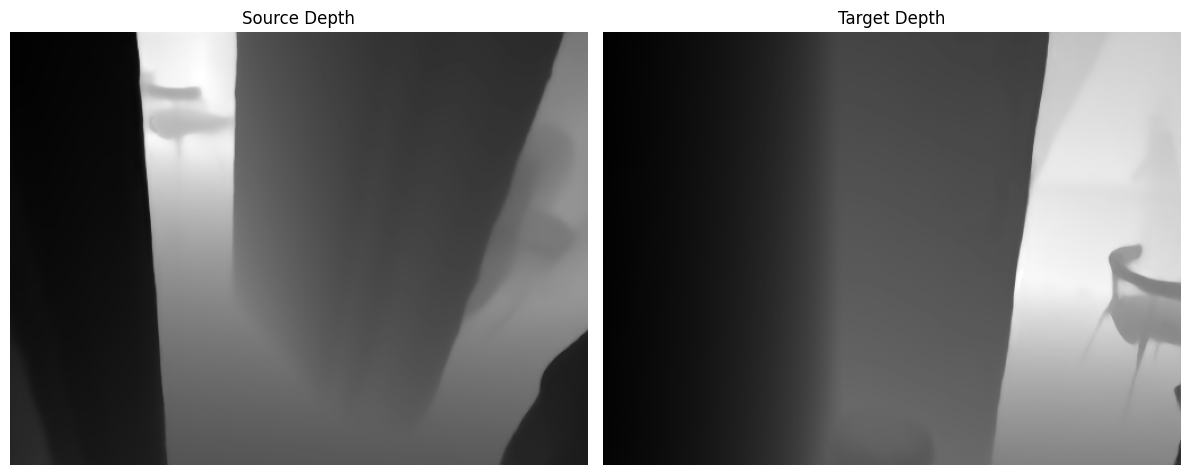

In [5]:
depths = to_numpy(scene.get_depthmaps())

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the source depth image
axes[0].imshow(depths[0], cmap='gray')  # Use 'gray' colormap for depth maps
axes[0].set_title('Source Depth')
axes[0].axis('off')  # Hide axis

# Display the target depth image
axes[1].imshow(depths[1], cmap='gray')
axes[1].set_title('Target Depth')
axes[1].axis('off')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [7]:
pts3d_img1_pred = pred1['pts3d'][0].detach().cpu().numpy()
pts3d_img2_pred = pred2['pts3d_in_other_view'][0].detach().cpu().numpy()

In [8]:
X_cam = pts3d_img1_pred[:, :, 0]
Y_cam = pts3d_img1_pred[:, :, 1]
Z_cam = pts3d_img1_pred[:, :, 2]

f_u = intrinsics[0, 0]
f_v = intrinsics[1, 1]
c_u = intrinsics[0, 2]
c_v = intrinsics[1, 2]

print(f_u, f_v, c_u, c_v)

H, W, _ = pts3d_img1.shape
print(H, W)

print(X_cam.min(), X_cam.max())

# u should be on the x axis
u = (f_u * X_cam / Z_cam) + c_u
# v should be on the y axis
v = (f_v * Y_cam / Z_cam) + c_v

print(u.shape)

# Stack into (N, 2) array
pts_2d = np.stack([u, v], axis=-1)
print(pts_2d.shape)

# create an image empty with H,W
image_depth = np.zeros((H, W))

pts_2d_torch = torch.from_numpy(pts_2d)
pts_2d_int = pts_2d_torch.round().long()

print(pts_2d_int.shape)
print(Z_cam.shape)

# Ensure points are valid after rounding
valid_indices = (pts_2d_int[:, :, 0] >= 0) & (pts_2d_int[:, :, 0] < W) & \
                (pts_2d_int[:, :, 1] >= 0) & (pts_2d_int[:, :, 1] < H)

# Filter valid points
pts_2d_valid = pts_2d_int[valid_indices]
Z_cam_valid = Z_cam[valid_indices]

# Assign Z_cam values to image_depth
image_depth[pts_2d_valid[:, 1], pts_2d_valid[:, 0]] = Z_cam_valid


423.89800211949 423.89800211949 256.36600000433 192.366600004333
384 512
-0.2849268 1.7778704
(384, 512)
(384, 512, 2)
torch.Size([384, 512, 2])
(384, 512)


In [9]:
focals = scene.get_focals().cpu().detach().numpy()

X_cam = pts3d_img1_pred[:, :, 0]
Y_cam = pts3d_img1_pred[:, :, 1]
Z_cam = pts3d_img1_pred[:, :, 2]

f_u = focals[0]
f_v = focals[1]
c_u = intrinsics[0, 2]
c_v = intrinsics[1, 2]

print(f_u, f_v, c_u, c_v)

H, W, _ = pts3d_img1.shape
print(H, W)

print(X_cam.min(), X_cam.max())

# u should be on the x axis
u = (f_u * X_cam / Z_cam) + c_u
# v should be on the y axis
v = (f_v * Y_cam / Z_cam) + c_v

print(u.shape)

# Stack into (N, 2) array
pts_2d_int_est = np.stack([u, v], axis=-1)
print(pts_2d_int_est.shape)

# create an image empty with H,W
image_depth_int_est = np.zeros((H, W))

pts_2d_torch = torch.from_numpy(pts_2d_int_est)
pts_2d_int = pts_2d_torch.round().long()

print(pts_2d_int.shape)
print(Z_cam.shape)

# Ensure points are valid after rounding
valid_indices = (pts_2d_int[:, :, 0] >= 0) & (pts_2d_int[:, :, 0] < W) & \
                (pts_2d_int[:, :, 1] >= 0) & (pts_2d_int[:, :, 1] < H)

# Filter valid points
pts_2d_valid = pts_2d_int[valid_indices]
Z_cam_valid = Z_cam[valid_indices]

# Assign Z_cam values to image_depth
image_depth_int_est[pts_2d_valid[:, 1], pts_2d_valid[:, 0]] = Z_cam_valid


[424.0001] [442.06226] 256.36600000433 192.366600004333
384 512
-0.2849268 1.7778704
(384, 512)
(384, 512, 2)
torch.Size([384, 512, 2])
(384, 512)


In [12]:
import torch

fu_tensor = torch.tensor(intrinsics[0, 0])
fv_tensor = torch.tensor(intrinsics[1, 1])
cu_tensor = torch.tensor(intrinsics[0, 2])
cv_tensor = torch.tensor(intrinsics[1, 2])

X_cam_tensor = torch.from_numpy(X_cam)
Y_cam_tensor = torch.from_numpy(Y_cam)
Z_cam_tensor = torch.from_numpy(Z_cam)

# Flatten the tensors
X_cam_flat = X_cam_tensor.view(-1)
Y_cam_flat = Y_cam_tensor.view(-1)
Z_cam_flat = Z_cam_tensor.view(-1)

# Project u and v
# Dimensions of the target image
H, W = X_cam_tensor.shape  # Replace with your actual image dimensions
print(H, W)

# Project u and v
u = (fu_tensor * X_cam_flat / Z_cam_flat) + cu_tensor
v = (fv_tensor * Y_cam_flat / Z_cam_flat) + cv_tensor

# Normalize u and v to [-1, 1]
u_normalized = 2.0 * (u / (W - 1)) - 1.0
v_normalized = 2.0 * (v / (H - 1)) - 1.0

# Stack and reshape normalized coordinates into a grid
grid = torch.stack((u_normalized, v_normalized), dim=1)  # Shape: (N, 2)
grid = grid.view(1, H, W, 2)  # Reshape for grid_sample (Batch, H, W, 2)

# Prepare Z_cam_flat as a source map (1x1xH_sourcexW_source)
Z_cam_flat_map = Z_cam_flat.view(1, 1, H, W)  # Assume Z_cam_flat is a valid 2D map

# Sample Z_cam_flat_map onto the target grid
image_depth_bilinear = F.grid_sample(Z_cam_flat_map, grid, mode='bilinear', padding_mode='zeros', align_corners=True)

# Reshape back to 2D (H, W)
image_depth_bilinear = image_depth_bilinear.squeeze(0).squeeze(0) 

print(image_depth_bilinear.shape)

384 512
torch.Size([384, 512])


In [15]:
import torch

fu_tensor = torch.tensor(focals[0])
fv_tensor = torch.tensor(focals[1])
cu_tensor = torch.tensor(intrinsics[0, 2])
cv_tensor = torch.tensor(intrinsics[1, 2])

X_cam_tensor = torch.from_numpy(X_cam)
Y_cam_tensor = torch.from_numpy(Y_cam)
Z_cam_tensor = torch.from_numpy(Z_cam)

# Flatten the tensors
X_cam_flat = X_cam_tensor.view(-1)
Y_cam_flat = Y_cam_tensor.view(-1)
Z_cam_flat = Z_cam_tensor.view(-1)

# Project u and v
# Dimensions of the target image
H, W = X_cam_tensor.shape  # Replace with your actual image dimensions
print(H, W)

# Project u and v
u = (fu_tensor * X_cam_flat / Z_cam_flat) + cu_tensor
v = (fv_tensor * Y_cam_flat / Z_cam_flat) + cv_tensor

# Normalize u and v to [-1, 1]
u_normalized = 2.0 * (u / (W - 1)) - 1.0
v_normalized = 2.0 * (v / (H - 1)) - 1.0

# Stack and reshape normalized coordinates into a grid
grid = torch.stack((u_normalized, v_normalized), dim=1)  # Shape: (N, 2)
grid = grid.view(1, H, W, 2)  # Reshape for grid_sample (Batch, H, W, 2)

# Prepare Z_cam_flat as a source map (1x1xH_sourcexW_source)
Z_cam_flat_map = Z_cam_flat.view(1, 1, H, W)  # Assume Z_cam_flat is a valid 2D map

# Sample Z_cam_flat_map onto the target grid
image_depth_bilinear_int_est = F.grid_sample(Z_cam_flat_map, grid, mode='bilinear', padding_mode='zeros', align_corners=True)

# Reshape back to 2D (H, W)
image_depth_bilinear_int_est = image_depth_bilinear_int_est.squeeze(0).squeeze(0) 

print(image_depth_bilinear_int_est.shape)

384 512
torch.Size([384, 512])


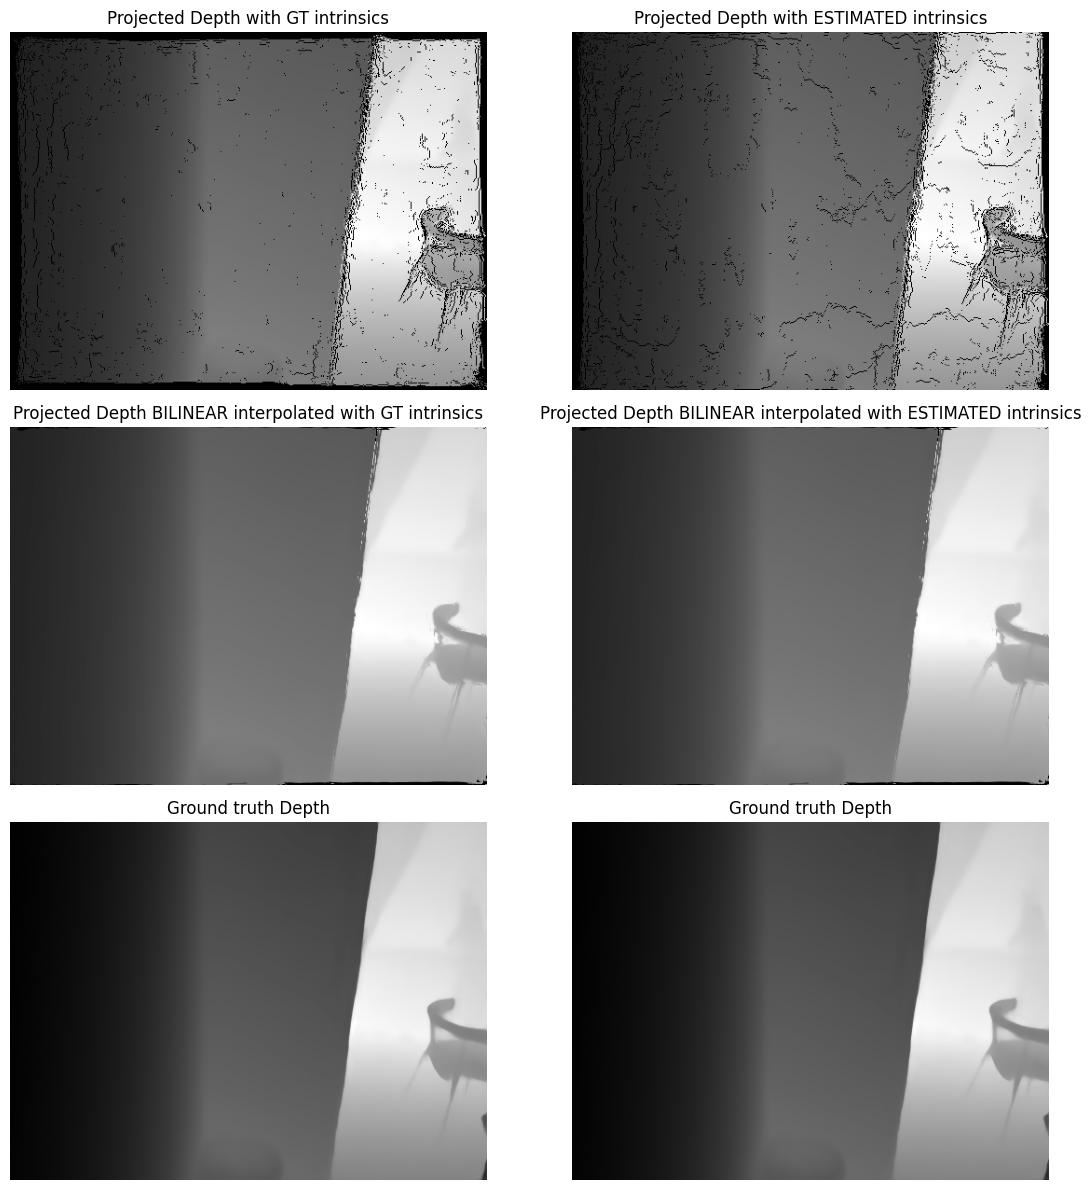

In [17]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Display the source depth image
axes[0, 0].imshow(image_depth, cmap='gray')  # Use 'gray' colormap for depth maps
axes[0, 0].set_title('Projected Depth with GT intrinsics')
axes[0, 0].axis('off')  # Hide axis

# Display the target depth image
axes[0, 1].imshow(image_depth_int_est, cmap='gray')
axes[0, 1].set_title('Projected Depth with ESTIMATED intrinsics')
axes[0, 1].axis('off')

# Display the source depth image
axes[1, 0].imshow(image_depth_bilinear, cmap='gray')  # Use 'gray' colormap for depth maps
axes[1, 0].set_title('Projected Depth BILINEAR interpolated with GT intrinsics')
axes[1, 0].axis('off')  # Hide axis

# Display the target depth image
axes[1, 1].imshow(image_depth_bilinear_int_est, cmap='gray')
axes[1, 1].set_title('Projected Depth BILINEAR interpolated with ESTIMATED intrinsics')
axes[1, 1].axis('off')

# Display the source depth image
axes[2, 0].imshow(depths[1], cmap='gray')  # Use 'gray' colormap for depth maps
axes[2, 0].set_title('Ground truth Depth')
axes[2, 0].axis('off')  # Hide axis

# Display the target depth image
axes[2, 1].imshow(depths[1], cmap='gray')
axes[2, 1].set_title('Ground truth Depth')
axes[2, 1].axis('off')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [18]:
def project_points_torch(pts_2d, rgb_values, image_height=192, image_width=256):
    """
    Vectorized point projection using PyTorch for a single image
    
    Args:
        pts_2d: Tensor of shape (N, 2) containing 2D coordinates
        target_rgb_image: Tensor of shape (N, 3) containing RGB values
        image_height: Height of the output image
        image_width: Width of the output image
    
    Returns:
        Projected image as a tensor
    """
    # Convert inputs to torch tensors if they aren't already
    if not isinstance(pts_2d, torch.Tensor):
        pts_2d = torch.from_numpy(pts_2d)
    if not isinstance(rgb_values, torch.Tensor):
        rgb_values = torch.from_numpy(rgb_values)
    
    # Create empty image tensor
    image = torch.zeros((image_height, image_width, 3), dtype=torch.uint8)
    
    # Round coordinates to integers
    pts_2d_int = pts_2d.round().long()
    
    valid_mask = (pts_2d_int[..., 1] >= 0) & (pts_2d_int[..., 1] < image_height) & \
                (pts_2d_int[..., 0] >= 0) & (pts_2d_int[..., 0] < image_width)
    
    print(valid_mask.shape)
    
    # Get valid coordinates and their corresponding RGB values    
    valid_coords = pts_2d_int[valid_mask]
    print("here")
    if(rgb_values.shape[0] == 3):
        rgb_values = rgb_values.permute(1,2,0)
    rgb_values = (rgb_values).byte()
    valid_rgb = rgb_values[valid_mask]  # Reshape RGB values to match coordinates
    
    # Project valid points
    image[valid_coords[:, 1], valid_coords[:, 0]] = valid_rgb

    valid_rgb = valid_rgb.float() / 255.0
    
    return image  

In [20]:
target_rgb_image_torch = torch.from_numpy(np.array(target_rgb_image)).permute(2, 0, 1).float()

In [21]:
X_cam = pts3d_img1_pred[:, :, 0]
Y_cam = pts3d_img1_pred[:, :, 1]
Z_cam = pts3d_img1_pred[:, :, 2]

f_u = focals[0]
f_v = focals[1]
c_u = intrinsics[0, 2]
c_v = intrinsics[1, 2]

print(f_u, f_v, c_u, c_v)

H, W, _ = pts3d_img1_pred.shape
print(H, W)

print(X_cam.min(), X_cam.max())

# u should be on the x axis
u = (f_u * X_cam / Z_cam) + c_u
# v should be on the y axis
v = (f_v * Y_cam / Z_cam) + c_v

print(u.shape)

# Stack into (N, 2) array
pts_2d = np.stack([u, v], axis=-1)
print("2dpts", pts_2d.shape)

print("rgb", target_rgb_image_torch.shape)

# Create the projected image
image = project_points_torch(pts_2d, target_rgb_image_torch, image_height=H, image_width=W)

[424.0001] [442.06226] 256.36600000433 192.366600004333
384 512
-0.2849268 1.7778704
(384, 512)
2dpts (384, 512, 2)
rgb torch.Size([3, 384, 512])
torch.Size([384, 512])
here


In [22]:
X_cam = pts3d_img1_pred[:, :, 0]
Y_cam = pts3d_img1_pred[:, :, 1]
Z_cam = pts3d_img1_pred[:, :, 2]

f_u = intrinsics[0, 0]
f_v = intrinsics[1, 1]
c_u = intrinsics[0, 2]
c_v = intrinsics[1, 2]

print(f_u, f_v, c_u, c_v)

H, W, _ = pts3d_img1_pred.shape
print(H, W)

print(X_cam.min(), X_cam.max())

# u should be on the x axis
u = (f_u * X_cam / Z_cam) + c_u
# v should be on the y axis
v = (f_v * Y_cam / Z_cam) + c_v

print(u.shape)

# Stack into (N, 2) array
pts_2d_int_est = np.stack([u, v], axis=-1)
print("2dpts", pts_2d_int_est.shape)

print("rgb", target_rgb_image_torch.shape)

# Create the projected image
image_int_est = project_points_torch(pts_2d_int_est, target_rgb_image_torch, image_height=H, image_width=W)

423.89800211949 423.89800211949 256.36600000433 192.366600004333
384 512
-0.2849268 1.7778704
(384, 512)
2dpts (384, 512, 2)
rgb torch.Size([3, 384, 512])
torch.Size([384, 512])
here


In [23]:
fu_tensor = torch.tensor(intrinsics[0, 0])
fv_tensor = torch.tensor(intrinsics[1, 1])
cu_tensor = torch.tensor(intrinsics[0, 2])
cv_tensor = torch.tensor(intrinsics[1, 2])

X_cam_tensor = torch.from_numpy(X_cam)
Y_cam_tensor = torch.from_numpy(Y_cam)
Z_cam_tensor = torch.from_numpy(Z_cam)

# Flatten the tensors
X_cam_flat = X_cam_tensor.view(-1)
Y_cam_flat = Y_cam_tensor.view(-1)
Z_cam_flat = Z_cam_tensor.view(-1)

# Project u and v
# Dimensions of the target image
H, W = X_cam_tensor.shape  # Replace with your actual image dimensions
print(H, W)

# Project u and v
u = (fu_tensor * X_cam_flat / Z_cam_flat) + cu_tensor
v = (fv_tensor * Y_cam_flat / Z_cam_flat) + cv_tensor

# Normalize u and v to [-1, 1]
u_normalized = 2.0 * (u / (W - 1)) - 1.0
v_normalized = 2.0 * (v / (H - 1)) - 1.0

print(u_normalized.max(), u_normalized.min())
print(v_normalized.max(), v_normalized.min())

# Stack and reshape normalized coordinates into a grid
grid = torch.stack((u_normalized, v_normalized), dim=1)  # Shape: (N, 2)
grid = grid.view(1, H, W, 2)  # Reshape for grid_sample (Batch, H, W, 2)

# Prepare Z_cam_flat as a source map (1x1xH_sourcexW_source)
target_rgb_image_torch_map = target_rgb_image_torch.view(1, 3, H, W)  # Assume Z_cam_flat is a valid 2D map
print(target_rgb_image_torch_map.shape)

# Sample Z_cam_flat_map onto the target grid
image_interpolated = F.grid_sample(target_rgb_image_torch_map, grid, mode='bilinear', padding_mode='zeros', align_corners=True)

# Reshape back to 2D (3, H, W)
image_interpolated = image_interpolated.squeeze(0)
print(image_interpolated.shape)

image_interpolated = image_interpolated.permute(1,2,0).detach().cpu().numpy() / 255.0

384 512
tensor(1.0135) tensor(-1.0035)
tensor(1.0159) tensor(-1.0225)
torch.Size([1, 3, 384, 512])
torch.Size([3, 384, 512])


In [24]:
fu_tensor = torch.tensor(focals[0])
fv_tensor = torch.tensor(focals[1])
cu_tensor = torch.tensor(intrinsics[0, 2])
cv_tensor = torch.tensor(intrinsics[1, 2])

X_cam_tensor = torch.from_numpy(X_cam)
Y_cam_tensor = torch.from_numpy(Y_cam)
Z_cam_tensor = torch.from_numpy(Z_cam)

# Flatten the tensors
X_cam_flat = X_cam_tensor.view(-1)
Y_cam_flat = Y_cam_tensor.view(-1)
Z_cam_flat = Z_cam_tensor.view(-1)

# Project u and v
# Dimensions of the target image
H, W = X_cam_tensor.shape  # Replace with your actual image dimensions
print(H, W)

# Project u and v
u = (fu_tensor * X_cam_flat / Z_cam_flat) + cu_tensor
v = (fv_tensor * Y_cam_flat / Z_cam_flat) + cv_tensor

# Normalize u and v to [-1, 1]
u_normalized = 2.0 * (u / (W - 1)) - 1.0
v_normalized = 2.0 * (v / (H - 1)) - 1.0

print(u_normalized.max(), u_normalized.min())
print(v_normalized.max(), v_normalized.min())

# Stack and reshape normalized coordinates into a grid
grid = torch.stack((u_normalized, v_normalized), dim=1)  # Shape: (N, 2)
grid = grid.view(1, H, W, 2)  # Reshape for grid_sample (Batch, H, W, 2)

# Prepare Z_cam_flat as a source map (1x1xH_sourcexW_source)
target_rgb_image_torch_map = target_rgb_image_torch.view(1, 3, H, W)  # Assume Z_cam_flat is a valid 2D map
print(target_rgb_image_torch_map.shape)

# Sample Z_cam_flat_map onto the target grid
image_interpolated_int_est = F.grid_sample(target_rgb_image_torch_map, grid, mode='bilinear', padding_mode='zeros', align_corners=True)

# Reshape back to 2D (3, H, W)
image_interpolated_int_est = image_interpolated_int_est.squeeze(0)

image_interpolated_int_est = image_interpolated_int_est.permute(1,2,0).detach().cpu().numpy() / 255.0

384 512
tensor(1.0137) tensor(-1.0037)
tensor(1.0592) tensor(-1.0665)
torch.Size([1, 3, 384, 512])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


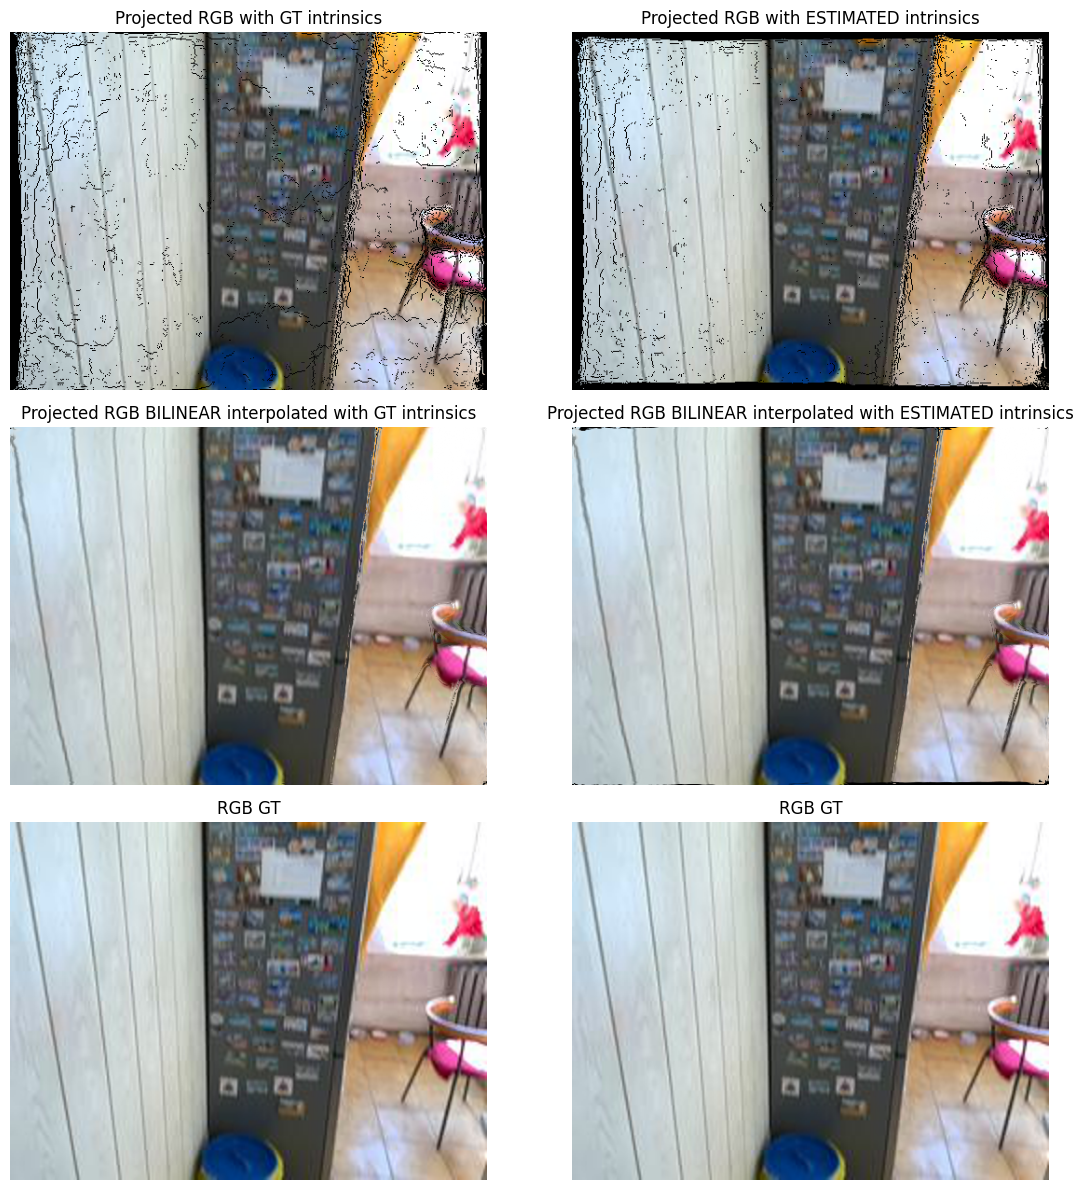

In [30]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Display the source depth image
axes[0, 0].imshow(image)  # Use 'gray' colormap for depth maps
axes[0, 0].set_title('Projected RGB with GT intrinsics')
axes[0, 0].axis('off')  # Hide axis

# Display the target depth image
axes[0, 1].imshow(image_int_est)
axes[0, 1].set_title('Projected RGB with ESTIMATED intrinsics')
axes[0, 1].axis('off')

# Display the source depth image
axes[1, 0].imshow(image_interpolated)  # Use 'gray' colormap for depth maps
axes[1, 0].set_title('Projected RGB BILINEAR interpolated with GT intrinsics')
axes[1, 0].axis('off')  # Hide axis

# Display the target depth image
axes[1, 1].imshow(image_interpolated_int_est)
axes[1, 1].set_title('Projected RGB BILINEAR interpolated with ESTIMATED intrinsics')
axes[1, 1].axis('off')

# Display the source depth image
axes[2, 0].imshow(np.array(target_rgb_image))  # Use 'gray' colormap for depth maps
axes[2, 0].set_title('RGB GT')
axes[2, 0].axis('off')  # Hide axis

# Display the target depth image
axes[2, 1].imshow(np.array(target_rgb_image))
axes[2, 1].set_title('RGB GT')
axes[2, 1].axis('off')


# Adjust layout and display
plt.tight_layout()
plt.show()